In [1]:
%matplotlib inline

import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
import sys

from collections import defaultdict, OrderedDict
matplotlib.style.use('ggplot')

# import RidiculusTaxi
import mytaxi

In [2]:
env = gym.make('Taxi-v3').unwrapped
numS = env.observation_space.n
numA = env.action_space.n
print("#state:{}, #action{}".format(numS, numA))

#state:501, #action6


In [3]:
def action_s(policy_s):
    p = policy_s / sum(policy_s)
    return np.random.choice(numA,p=p)

In [4]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):

    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    for i_episode in range(1, num_episodes + 1):

        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        done=False
        while not done:
            
            action = action_s(policy[state])
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all states the we've visited in this episode
        states_in_episode = set([x[0] for x in episode])
        for state in states_in_episode:
            # Find the first occurance of the state in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]

    return V    

In [5]:
def plot_value_function(V, baseline, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    V_ordered = OrderedDict(sorted(V.items()))
    
    print('\n')
    print(len(V.keys()))
    
    v_s = np.zeros(len(V.keys()))
    idx = 0
    for key, val in V_ordered.items():
        v_s[idx] = val
        idx +=1

    # print(np.sort(np.asarray(V.keys())))

#     plt.plot(np.asarray(v_s), marker='o',linewidth=2)
    plt.plot(v_s,marker='o',linestyle='None',label='mc')
    plt.plot(baseline,marker='x',linestyle='None',label='base')
    plt.legend(["MC", "Baseline"])
    plt.title(title)
    plt.xlabel("State", fontsize=20)
    plt.savefig("mc_prediction.png")

Episode 10000/10000.

497


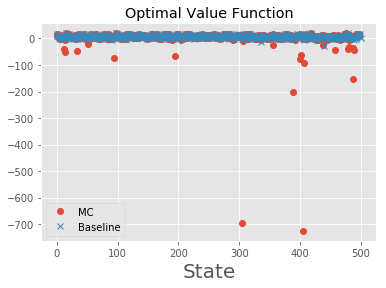

In [6]:
# evaluate the given policy
with open('qpolicy','r') as fp:
    policy = eval(fp.read())
        
V_10k = mc_prediction(policy, env, num_episodes=10000)
# plot_value_function(V_10k, title="100,000 Epesodes")
baseline = np.load('baseline.npy')
plot_value_function(V_10k, baseline, title="Optimal Value Function")
